# Coursework: Self-supervised learning

In this coursework, you will explore the popular self-supervised contrastive learning approach [SimCLR]((https://arxiv.org/abs/2002.05709)).

You will be asked to implement some of the key components of SimCLR, including a suitable data augmentation strategy (for generating positive pairs), the SimCLR loss function, and the SimCLR training step. Additionally, you will be using transfer learning strategies for evaluating the performance of different pre-trained models for a downstream classification task.

The coursework is divided into three-parts:
- **Part A:** Implementation of a suitable dataset for contrastive model training;
- **Part B:** Implementation of the SimCLR loss and training step;
- **Part C:** Implementation of transfer learning strategies (linear probing and finetuning) for model evaluation.

**Important:** Read the text descriptions carefully and look out for hints and comments indicating a specific 'TASK'. Make sure to add sufficient documentation to your code.

**Submission:** You are asked to submit two versions of your notebook:
1. You should submit the raw notebook in `.ipynb` format with *all outputs cleared*. Please name your file `coursework.ipynb`.
2. Additionally, you will be asked to submit an exported version of your notebook in `.pdf` format, with *all outputs included*. We will primarily use this version for marking, but we will use the raw notebook to check for correct implementations. Please name this file `coursework_export.pdf`.

## Your details

Please add your details below. You can work in groups up to two.

Authors: **Tao Wang** & **firstname2 lastname2**

DoC alias: **tw520** & **alias2**

## Setup

In [3]:
# On Google Colab uncomment the following line to install PyTorch Lightning and the MedMNIST dataset
# ! pip install lightning medmnist

     ---------------------------------------- 0.0/56.8 kB ? eta -:--:--
     -------------------- ----------------- 30.7/56.8 kB 660.6 kB/s eta 0:00:01
     -------------------------------------- 56.8/56.8 kB 751.7 kB/s eta 0:00:00
     ---------------------------------------- 0.0/88.3 kB ? eta -:--:--
     ---------------------------------------- 88.3/88.3 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
   -------------- ------------------------- 0.7/2.1 MB 23.1 MB/s eta 0:00:01
   ---------------------------------------  2.0/2.1 MB 25.6 MB/s eta 0:00:01
   ---------------------------------------- 2.1/2.1 MB 18.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/840.4 kB ? eta -:--:--
   --------------------------------------- 840.4/840.4 kB 26.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/800.9 kB ? eta 


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: C:\Users\taow\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [4]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torchvision import models
from torchvision import transforms
from pytorch_lightning import LightningModule, LightningDataModule, Trainer, seed_everything
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint, TQDMProgressBar
from torchmetrics.functional import auroc
from PIL import Image
from medmnist.info import INFO
from medmnist.dataset import MedMNIST

## **Part A:** Implement a dataset suitable for contrastive learning.

We will be using the [MedMNIST Pneumonia](https://medmnist.com/) dataset, which is a medical imaging inspired dataset but with the characteristics of MNIST. This allows efficient experimentation due to the small image size. The dataset contains real chest X-ray images but downsampled to 28 x 28 pixels, with binary labels indicating the presence of [Pneumonia](https://www.nhs.uk/conditions/pneumonia/) (which is an inflammation of the lungs).

### **Task A-1:** Complete the dataset implementation.

You are asked to implement a dataset class `SimCLRPneumoniaMNISTDataset` suitable for training a self-supervised model with a contrastive objective. For each sample, your dataset class should return two 'views' of the corresponding image, forming the positive pairs for contrastive learning. It is up to you to design suitable augmentation pipeline for generating these views. Please provide a short description in plain language of what your data augmentation pipeline is meant to do.

To get you started, we have provided the skeleton of the dataset class in the cell below. Once you have implemented your dataset class, you are asked to run the provided visualisation code to visualise one batch of your training dataloader.

*Note:* You can use the same data augmentation pipeline for training, validation, and testing.

In [11]:
class SimCLRPneumoniaMNISTDataset(MedMNIST):
    def __init__(self, split = 'train'):
        ''' Dataset class for PneumoniaMNIST.
        The provided init function will automatically download the necessary
        files at the first class initialistion.

        :param split: 'train', 'val' or 'test', select subset

        '''
        self.flag = "pneumoniamnist"
        self.size = 28
        self.size_flag = ""
        self.root = './data/coursework/'
        self.info = INFO[self.flag]
        self.download()

        npz_file = np.load(os.path.join(self.root, "pneumoniamnist.npz"))

        self.split = split

        # Load all the images
        assert self.split in ['train','val','test']

        self.imgs = npz_file[f'{self.split}_images']
        self.labels = npz_file[f'{self.split}_labels']

        # TASK: Define here your data augmentation pipeline
        # Add a short description in plain language.
        self.augmentation_pipeline = transforms.Compose([
            transforms.ToPILImage(),  # Ensure we have a PIL Image for the following transforms
            transforms.Resize((32, 32)),  # Increase image size to allow for crops after rotations
            transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
            transforms.ToTensor(),  # Convert back to tensor for GaussianBlur
            transforms.CenterCrop((28, 28)),  # Crop back down to the original size
            transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0))  # Apply Gaussian blur with a random sigma
        ])

    def __len__(self):
        return self.imgs.shape[0]

    def __getitem__(self, index):
        # TASK: Fill in the blanks such that you return two tensors
        # of shape [1, 28, 28], img_view1 and img_view2, representing two augmented view of the images.
        img = self.imgs[index]

        if not isinstance(img, torch.Tensor):
            img = transforms.ToTensor()(img)
        
        # Apply the augmentation pipeline to the image twice to
        # generate two different views of the same image
        img_view1 = self.augmentation_pipeline(img)
        img_view2 = self.augmentation_pipeline(img)

        return img_view1, img_view2

We use a [LightningDataModule](https://lightning.ai/docs/pytorch/stable/data/datamodule.html) for handling your PneumoniaMNIST dataset. You do not need to make any modifications to the code below.

In [12]:
class SimCLRPneumoniaMNISTDataModule(LightningDataModule):
    def __init__(self, batch_size: int = 8):
        super().__init__()
        self.batch_size = batch_size
        self.train_set = SimCLRPneumoniaMNISTDataset(split='train')
        self.val_set = SimCLRPneumoniaMNISTDataset(split='val')
        self.test_set = SimCLRPneumoniaMNISTDataset(split='test')

    def train_dataloader(self):
        return DataLoader(dataset=self.train_set, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(dataset=self.val_set, batch_size=self.batch_size, shuffle=False)

    def test_dataloader(self):
        return DataLoader(dataset=self.test_set, batch_size=self.batch_size, shuffle=False)

#### **Check** dataset implementation.

Run the below cell to visualise a batch of your training dataloader.

Using downloaded and verified file: ./data/coursework/pneumoniamnist.npz
Using downloaded and verified file: ./data/coursework/pneumoniamnist.npz
Using downloaded and verified file: ./data/coursework/pneumoniamnist.npz


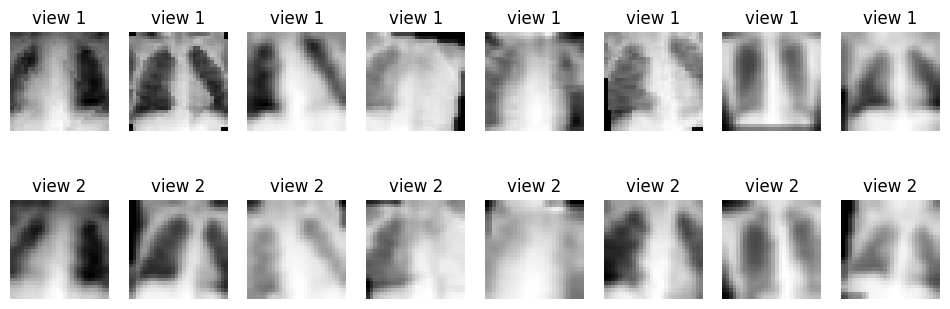

In [13]:
# DO NOT MODIFY THIS CELL! IT IS FOR CHECKING THE IMPLEMENTATION ONLY.

# Initialise data module
datamodule = SimCLRPneumoniaMNISTDataModule()
# Get train dataloader
train_dataloader = datamodule.train_dataloader()
# Get first batch
batch = next(iter(train_dataloader))
# Visualise the images
view1, view2 = batch
f, ax = plt.subplots(2, 8, figsize=(12,4))
for i in range(8):
  ax[0,i].imshow(view1[i, 0], cmap='gray')
  ax[1,i].imshow(view2[i, 0], cmap='gray')
  ax[0,i].set_title('view 1')
  ax[1,i].set_title('view 2')
  ax[0, i].axis("off")
  ax[1, i].axis("off")

## **Part B:** Implement the SimCLR loss and training step.

In this part, we ask you to:
1. Implement the SimCLR loss function, as per the equation in the lecture notes (and the [original paper](https://arxiv.org/abs/2002.05709)).
2. Once you have implemented the loss, implement the training step function in the provided LightningModule.

### **Task B-1:** SimCLR loss function.

For the implementation of the SimCLR loss, you should follow the 'recipe' from the lecture slides. We provide a code skeleton to get you started. Fill in all the blanks.

*Hint:* In PyTorch, to compute scalar products (also called dot products) between many elements efficiently, note that for two batches of $d$-dimensional feature vectors $v1$ and $v2$ of size $[N, d]$ (with $N$ being the batch size) computing the matrix multiplication `torch.mm(v1, v2.t())` returns a matrix $S$ of size $[N, N]$ where each element $S[i, j]$ is the scalar product of $v1_i$ and $v2_j$.

In [16]:
def simclr_loss(embedding_view1, embedding_view2, tau = 1.0):
  '''
  This funtion implements the SimCLR loss function as described in the original paper.
  See lecture notes for formulas.

  It takes as input the embeddings from both views and returns the loss value for that batch.
  Args:
    embedding_view1: torch tensor of shape [batch_size, embedding_dimension]
    embedding_view2: torch tensor of shape [batch_size, embedding_dimension]
  Returns:
    loss: torch.tensor of shape 1
  '''

  # Step 1: normalise the embeddings
  z = torch.cat((embedding_view1, embedding_view2), dim=0)
  z_norm = F.normalize(z, dim=1)

  # Step 2: gather all embeddings into one big vector of size [2*N , feature_dim]
  sim_matrix = torch.mm(z_norm, z_norm.T) / tau

  # Step 3: compute all possible similarities, should be a matrix of size [2 * N, 2 * N]
  # all_similarities[i,j] will be the similarity between z_all_views[i] and z_all_views[j].
  # Use the hint.
  sim_matrix.fill_diagonal_(-np.inf)
  labels = torch.arange(2 * embedding_view1.size(0), device=embedding_view1.device)
  labels = (labels + embedding_view1.size(0)) % (2 * embedding_view1.size(0))

  # Step 4: Here we want to return a mask of size[2 * N, 2* N] for which mask[i,j] = 1 if
  # z_all_views[i] and z_all_views[j] form a positive pair.
  # There should be exactely 2 * N non-zeros elements in this matrix.
  loss = F.cross_entropy(sim_matrix, labels)

  # Step 5: self-mask. For computing the denominator term in the loss function,
  # we need to sum over all possible similarities except the self-similarity.
  # Create a mask of shape [2*N, 2*N] that is 1 for all valid pairs and 0 for all self-pairs (i = j).
  ...

  # Step 6: Computing all numerators for the loss function.
  # Should be vector of size [2 * N],
  # where element is exp(sim(i, j) / t) for each positive pair (i, j).
  # Re-use the computed quantities above.
  

  # Step 7: Computing all denominators for the loss function.
  # Should be a vector of size [2 * N].
  # Where each element should be the sum of exp(sim(i,k)/tau) for all k != i.
  

  # Step 8: Return the final loss values, using the previously computing numerators and denominators.
  

  # return torch.tensor(0.0)
  return loss

#### **Check** SimCLR loss function.

To check your implementation, please run the following tests. Note that we will also use other tests on different inputs to test your code.

In [17]:
# DO NOT MODIFY THIS CELL! IT IS FOR CHECKING THE IMPLEMENTATION ONLY.

seed_everything(33)

expected_results = [torch.tensor(1.7518), torch.tensor(1.6376), torch.tensor(4.194),  torch.tensor(4.1754)]
for i, (N, feature_dim) in enumerate(zip([3, 3, 33, 33], [5, 125, 5, 125])):
  embedding_view1 = torch.rand((N, feature_dim))
  embedding_view2 = torch.rand((N, feature_dim))
  loss = simclr_loss(embedding_view1.clone(), embedding_view2.clone(), tau=0.5)
  print(f"Expected loss: {expected_results[i]}, Computed loss: {loss}")
  assert torch.isclose(loss, expected_results[i], rtol=1e-3)
print("Passed all tests successfully !")

Seed set to 33


Expected loss: 1.7517999410629272, Computed loss: 1.7518142461776733
Expected loss: 1.6375999450683594, Computed loss: 1.6376436948776245
Expected loss: 4.193999767303467, Computed loss: 4.194351673126221
Expected loss: 4.1753997802734375, Computed loss: 4.175372123718262
Passed all tests successfully !


### **Task B-2:** SimCLR training step.

In this next task you are asked to complete the blanks in the provided [LightningModule](https://lightning.ai/docs/pytorch/stable/common/lightning_module.html).

We provide the implementation of an image encoder (the CNN backbone that will act as feature extractor). No changes are needed for this part.

In [20]:
class ImageEncoder(torch.nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.net = models.resnet50(weights=None)
        del self.net.fc
        self.net.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.net.conv1(x)
        x = self.net.bn1(x)
        x = self.net.relu(x)
        x0 = self.net.maxpool(x)
        x1 = self.net.layer1(x0)
        x2 = self.net.layer2(x1)
        x3 = self.net.layer3(x2)
        x4 = self.net.layer4(x3)
        x4 = self.net.avgpool(x4)
        x4 = torch.flatten(x4, 1)
        return x4

Next, you will need to complete the implementation of the SimCLR model. In order to make the training step work correctly, you will need to implement the `process_batch` function.

In [21]:
class SimCLRModel(LightningModule):
    def __init__(self, learning_rate: float = 0.001):
        super().__init__()
        self.learning_rate = learning_rate

        self.encoder = ImageEncoder()

        self.projector = torch.nn.Sequential(
            torch.nn.Linear(2048, 1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024, 128),
        )

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    def process_batch(self, batch):
        # TASK: Implement the process_batch function
        (view1, view2) = batch

        embedding_view1 = self.projector(self.encoder(view1))
        embedding_view2 = self.projector(self.encoder(view2))

        loss = simclr_loss(embedding_view1, embedding_view2, tau=0.5)
        return loss

    def training_step(self, batch, batch_idx):
        loss = self.process_batch(batch)
        self.log('train_loss', loss, prog_bar=True)
        if batch_idx == 0:
            grid = torchvision.utils.make_grid(torch.cat((batch[0][0:4, ...], batch[1][0:4, ...]), dim=0), nrow=4, normalize=True)
            self.logger.experiment.add_image('train_images', grid, self.global_step)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self.process_batch(batch)
        self.log('val_loss', loss, prog_bar=True)

#### **Check** SimCLR training step.

Here you can test that your code runs fine by training the model for 5 epochs using the cell below.

Report the training and validation loss at the end of 5 epochs.

In [22]:
# DO NOT MODIFY THIS CELL! IT IS FOR CHECKING THE IMPLEMENTATION ONLY.

seed_everything(33, workers=True)

data = SimCLRPneumoniaMNISTDataModule(batch_size=32)

model = SimCLRModel()

trainer = Trainer(
    max_epochs=5,
    accelerator='auto',
    devices=1,
    logger=TensorBoardLogger(save_dir='./lightning_logs/coursework/', name='simclr'),
    callbacks=[ModelCheckpoint(monitor='val_loss', mode='min'), TQDMProgressBar(refresh_rate=10)],
)
trainer.fit(model=model, datamodule=data)

Seed set to 33


Using downloaded and verified file: ./data/coursework/pneumoniamnist.npz
Using downloaded and verified file: ./data/coursework/pneumoniamnist.npz
Using downloaded and verified file: ./data/coursework/pneumoniamnist.npz


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ./lightning_logs/coursework/simclr



  | Name      | Type         | Params
-------------------------------------------
0 | encoder   | ImageEncoder | 23.5 M
1 | projector | Sequential   | 2.2 M 
-------------------------------------------
25.7 M    Trainable params
0         Non-trainable params
25.7 M    Total params
102.925   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\taow\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
C:\Users\taow\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

C:\Users\taow\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pytorch_lightning\trainer\call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


## **Part C:** Linear probing and model finetuning.

In this part, you are given two different image encoders that were pre-trained with different datasets and training strategies. The objective for this task is to assess the performance of these two encoders in a downstream classification task. This this end, you are asked to implement evaluation routines seen in the lecture: linear probing and model finetuning. The downstream task is the prediction of Pneumonia in the (small) chest X-ray images from the PneumoniaMNIST dataset.

This part can be broken down into the following tasks:
1. Adapt your PneunomiaMNIST dataset for the image classification task.
2. Implement a classification model with a linear layer attached to a pre-trained image encoder.
3. For both pre-trained encoders:
    - a) Train the classifier on top of the frozen encoder (linear probing)
    - b) Finetune the entire model (including the encoder).
4. Evaluate all models on the test set, and provide a brief summary (no more than 300 words) with an analysis of your findings.

### **Task C-1:** Adapt your PneunomiaMNIST dataset for the image classification task.

We can base our implementation largely on the `SimCLRPneumoniaMNISTDataset` and adapt it to make it suitable for image classification. Think about a suitable data augmentation pipeline. Check previous tutorials for inspiration.

In [23]:
class PneumoniaMNISTDataset(MedMNIST):
    def __init__(self, split = 'train', augmentation: bool = False):
        ''' Dataset class for Pneumonia MNST.
        The provided init function will automatically download the necessary
        files at the first class initialistion.

        :param split: 'train', 'val' or 'test', select subset

        '''
        self.flag = "pneumoniamnist"
        self.size = 28
        self.size_flag = ""
        self.root = './data/coursework/'
        self.info = INFO[self.flag]
        self.download()

        npz_file = np.load(os.path.join(self.root, "pneumoniamnist.npz"))

        self.split = split

        # Load all the images
        assert self.split in ['train','val','test']

        self.imgs = npz_file[f'{self.split}_images']
        self.labels = npz_file[f'{self.split}_labels']

        self.do_augment = augmentation

        # TASK: Define here your data augmentation pipeline suitable for classification.
        # Check previous tutorials for inspiration.
        if self.do_augment:
            # Define the data augmentation pipeline
            self.augmentation_pipeline = transforms.Compose([
                transforms.ToTensor(),
                transforms.Resize((32, 32)),  # Resize to allow for random cropping
                transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
                transforms.RandomHorizontalFlip(),
                transforms.Normalize(mean=[0.5], std=[0.5])  # Assuming grayscale images
            ])
        else:
            # No augmentation, just convert to tensor and normalize
            self.augmentation_pipeline = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5], std=[0.5])
            ])

    def __len__(self):
        return self.imgs.shape[0]

    def __getitem__(self, index):
        # TASK: Implement the __getitem__ function to return the image and its class label.
        img = self.imgs[index]
        label = self.labels[index]
        
        # Apply data augmentation pipeline (if applicable)
        img = self.augmentation_pipeline(img)
        return img, label

Again, we use a [LightningDataModule](https://lightning.ai/docs/pytorch/stable/data/datamodule.html) for handling your PneumoniaMNIST dataset. No changes needed for this part.

In [24]:
class PneumoniaMNISTDataModule(LightningDataModule):
    def __init__(self, batch_size: int = 32):
        super().__init__()
        self.batch_size = batch_size
        self.train_set = PneumoniaMNISTDataset(split='train', augmentation=True)
        self.val_set = PneumoniaMNISTDataset(split='val', augmentation=False)
        self.test_set = PneumoniaMNISTDataset(split='test', augmentation=False)

    def train_dataloader(self):
        return DataLoader(dataset=self.train_set, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(dataset=self.val_set, batch_size=self.batch_size, shuffle=False)

    def test_dataloader(self):
        return DataLoader(dataset=self.test_set, batch_size=self.batch_size, shuffle=False)

#### **Check** dataset implementation.

Run the below cell to visualise a batch of your training dataloader.

Using downloaded and verified file: ./data/coursework/pneumoniamnist.npz
Using downloaded and verified file: ./data/coursework/pneumoniamnist.npz
Using downloaded and verified file: ./data/coursework/pneumoniamnist.npz


C:\Users\taow\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


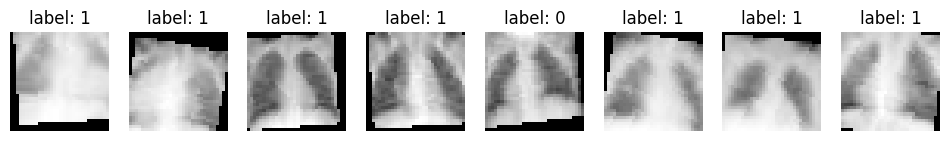

In [25]:
# DO NOT MODIFY THIS CELL! IT IS FOR CHECKING THE IMPLEMENTATION ONLY.

# Initialise data module
datamodule = PneumoniaMNISTDataModule()
# Get train dataloader
train_dataloader = datamodule.train_dataloader()
# Get first batch
batch = next(iter(train_dataloader))
# Visualise the images
images, labels = batch
f, ax = plt.subplots(1, 8, figsize=(12,4))
for i in range(8):
  ax[i].imshow(images[i, 0], cmap='gray')
  ax[i].set_title('label: ' + str(labels[i].item()))
  ax[i].axis("off")

### **Task C-2:** Implement a classification model with a linear layer attached to a pre-trained image encoder.

We first download the weights of the two pre-trained image encoders. One of them has been trained with the self-supervised SimCLR objective on a large publicly available chest X-ray dataset (different from PneunomiaMNIST). The other encoder is a standard ImageNet backbone that has been trained with a supervised classification objective on the ImageNet dataset.

In [26]:
! wget https://www.doc.ic.ac.uk/~bglocker/teaching/mli/coursework.zip
! unzip coursework.zip

'wget' is not recognized as an internal or external command,
operable program or batch file.
'unzip' is not recognized as an internal or external command,
operable program or batch file.


We provide the function for loading the encoders. No changes needed here.

In [ ]:
def load_encoder_from_checkpoint(checkpoint_path):
  ckpt = torch.load(checkpoint_path, map_location='cpu')
  simclr_module = SimCLRModel()
  print(simclr_module.load_state_dict(state_dict=ckpt))
  return simclr_module.encoder.eval()

imagenet_model = './data/coursework/model_imagenet.ckpt'
chestxray_model = './data/coursework/model_chestxray.ckpt'

Now, implement a classification model as a LightningModule for image classification using a pre-trained image encoder.

The model should have a flag in the init function `freeze_encoder` that if set to true freezes all the weights in the encoder (used for linear probing), and if set to false all weights are trainable (used for model finetuning).

*Hint:* Check out previous tutorials for inspiration on how to implement a classification model as LightningModule. For the coursework, we recommend using the Area Under the Receiver Operating Characteristic Curve (ROC-AUC) performance metric (instead of accuracy). ROC-AUC is measure of the overall discriminative power of a classification model. You can use the readily available implementation in [torchmetrics](https://lightning.ai/docs/torchmetrics/stable/classification/auroc.html#functional-interface). You should log the ROC-AUC similar to how we logged accuracy in previous tutorials.

In [28]:
# TASK: Implement the ImageClassifier class
# Check previous tutorials for insipration how to implement an `ImageClassifier`

class ImageClassifier(LightningModule):
    def __init__(self, pretrained_encoder: torch.nn.Module, freeze_encoder: bool = True, output_dim: int = 2, learning_rate: float = 0.001):
        super().__init__()
        self.learning_rate = learning_rate

        # Use the provided pre-trained encoder
        self.encoder = pretrained_encoder
        
        # Optionally freeze the encoder
        if freeze_encoder:
            for param in self.encoder.parameters():
                param.requires_grad = False
        
        # Classifier head
        self.classifier = torch.nn.Linear(self.encoder.fc.in_features, output_dim)
        
        # Save hyperparameters
        self.save_hyperparameters()
    
    def forward(self, x):
        # Use the encoder to get the feature representation
        features = self.encoder(x)
        # Classify the features
        return self.classifier(features)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        preds = F.softmax(logits, dim=1)
        auroc_score = auroc(preds, y, num_classes=self.hparams.output_dim)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_auroc', auroc_score, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        preds = F.softmax(logits, dim=1)
        auroc_score = auroc(preds, y, num_classes=self.hparams.output_dim)
        self.log('val_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('val_auroc', auroc_score, on_step=True, on_epoch=True, prog_bar=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

### **Task C-3a:** Implement training and testing for linear probing.

Train two classification models using linear probing, one for each of the two provided image encoders. Evaluate on both the validation and test sets.

*Note:* Training for 25 epochs should be sufficient.

In [30]:
seed_everything(33, workers=True)

data = PneumoniaMNISTDataModule(batch_size=32)

# TASK: Implement the linear probing training and testing routines.
data.prepare_data()
data.setup('fit')
data.setup('test')

# Load the pre-trained image encoders
encoder_imagenet = load_encoder_from_checkpoint('./data/coursework/model_imagenet.ckpt')
encoder_chestxray = load_encoder_from_checkpoint('./data/coursework/model_chestxray.ckpt')

# Create the classifier models
classifier_imagenet = ImageClassifier(pretrained_encoder=encoder_imagenet, freeze_encoder=True)
classifier_chestxray = ImageClassifier(pretrained_encoder=encoder_chestxray, freeze_encoder=True)

# Initialize a trainer
trainer = Trainer(
    max_epochs=25,
    gpus=1 if torch.cuda.is_available() else 0,  # Use GPU if available
    callbacks=[ModelCheckpoint(monitor='val_auroc', mode='max', verbose=True)]
)

# Train the models
print("Training with ImageNet encoder")
trainer.fit(classifier_imagenet, datamodule=data)

print("Training with Chest X-Ray encoder")
trainer.fit(classifier_chestxray, datamodule=data)

# Evaluate the models on the test set
result_imagenet = trainer.test(classifier_imagenet, datamodule=data)
result_chestxray = trainer.test(classifier_chestxray, datamodule=data)

print("Results for ImageNet encoder:", result_imagenet)
print("Results for Chest X-Ray encoder:", result_chestxray)

Seed set to 33


Using downloaded and verified file: ./data/coursework/pneumoniamnist.npz
Using downloaded and verified file: ./data/coursework/pneumoniamnist.npz
Using downloaded and verified file: ./data/coursework/pneumoniamnist.npz


NameError: name 'load_encoder_from_checkpoint' is not defined

### **Task C-3b:** Implement training and testing for model finetuning.

Repeat the experiments, but this time using model finetuning instead of linear probing. Evaluate on both the validation and test sets.

In [31]:
seed_everything(33, workers=True)

data = PneumoniaMNISTDataModule(batch_size=32)

# TASK: Implement the model finetuning training and testing routines.

# Load the pre-trained image encoders
encoder_imagenet = load_encoder_from_checkpoint('model_imagenet.ckpt')
encoder_chestxray = load_encoder_from_checkpoint('model_chestxray.ckpt')

# Create the classifier models with encoder weights unfrozen for fine-tuning
classifier_imagenet = ImageClassifier(pretrained_encoder=encoder_imagenet, freeze_encoder=False)
classifier_chestxray = ImageClassifier(pretrained_encoder=encoder_chestxray, freeze_encoder=False)

# Initialize the trainer with callbacks for early stopping and best model checkpointing
trainer = Trainer(
    max_epochs=25,
    gpus=1 if torch.cuda.is_available() else 0,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=3, verbose=True),
        ModelCheckpoint(monitor='val_auroc', mode='max', verbose=True)
    ]
)

# Train the ImageNet-based model
trainer.fit(classifier_imagenet, datamodule=data)

# Train the Chest X-ray-based model
trainer.fit(classifier_chestxray, datamodule=data)

# Evaluate the ImageNet-based model on the test set
imagenet_results = trainer.test(classifier_imagenet, datamodule=data.test_dataloader())

# Evaluate the Chest X-ray-based model on the test set
chestxray_results = trainer.test(classifier_chestxray, datamodule=data.test_dataloader())

# Output the results
print('ImageNet-based model test results:', imagenet_results)
print('Chest X-ray-based model test results:', chestxray_results)

Seed set to 33


Using downloaded and verified file: ./data/coursework/pneumoniamnist.npz
Using downloaded and verified file: ./data/coursework/pneumoniamnist.npz
Using downloaded and verified file: ./data/coursework/pneumoniamnist.npz


NameError: name 'load_encoder_from_checkpoint' is not defined

### **Task C-4:** Your evaluation report.

Provide a brief summary (no more than 300 words) with an analysis of your findings. Try explaining the observed performance.

*Placeholder text with 300 words:*

Lorem ipsum dolor sit amet, consectetur adipiscing elit. Sed id enim ut nibh pretium egestas. Maecenas at felis vel justo viverra ornare. Ut elit erat, sagittis in augue vel, ultrices pulvinar orci. Mauris posuere consequat lorem, non sodales purus convallis sed. Fusce ut purus eu risus pellentesque imperdiet quis a felis. Ut neque mi, porta vulputate metus in, ultrices consectetur mi. Ut eu fringilla turpis, vel accumsan felis.

Morbi maximus, nunc quis accumsan euismod, sem urna eleifend lorem, non consequat mauris diam eget elit. Praesent at massa ante. Nulla semper, turpis eget elementum iaculis, felis ex ultricies mauris, ac lobortis odio dui ut massa. Morbi luctus varius turpis, sed maximus erat ullamcorper nec. Etiam quis magna in neque commodo pretium ac nec lacus. Etiam ornare euismod pharetra. Etiam pellentesque est at lectus iaculis, et semper tellus cursus. Integer blandit tellus lacus, ac cursus nisi aliquam quis. Donec ut aliquam erat. Duis at quam at velit malesuada sagittis. Aliquam vestibulum tellus vitae nibh finibus ullamcorper. Lorem ipsum dolor sit amet, consectetur adipiscing elit. In pretium eros et est auctor ultricies. Curabitur lectus velit, vulputate blandit turpis eget, maximus interdum nunc.

Sed tincidunt scelerisque magna ut congue. Nulla porttitor a ante ac pellentesque. Nam porttitor velit vehicula, euismod ligula vitae, sagittis tortor. Mauris ut cursus augue. Morbi nec rhoncus sem. Fusce id dolor in elit faucibus laoreet. Quisque tempus odio non nisl elementum volutpat. Donec facilisis, urna sit amet congue pretium, metus ex vulputate magna, ut vulputate quam erat eu est. Aliquam diam magna, volutpat porta orci posuere, varius ornare odio. Nullam interdum faucibus sodales. Maecenas hendrerit sollicitudin erat, ut vestibulum neque interdum ac. Sed molestie suscipit rutrum. Aenean vitae ante purus. Sed sed maximus nibh. Nulla facilisi. Sed sit amet turpis vitae libero sagittis molestie a in ante. Sed ultricies interdum.

## Logging

In [ ]:
%load_ext tensorboard
%tensorboard --logdir './lightning_logs/coursework/'